# MULTIHEAD ATTENTION

In [1]:
import numpy as np
import polars as pl
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

import re
from typing import List, Dict, Any, Tuple, Optional, Mapping, Set, Self, NamedTuple, TypedDict

In [2]:
def fix_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# BUILD TRANSFORMER

In [3]:
class RMSNorm(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        eps: float = 1e-6,
        bias: bool = False,
    ) -> None:
        super().__init__()
        self._eps = eps
        self._scale = nn.Parameter(torch.ones(embedding_size))
        self._shift = nn.Parameter(torch.zeros(embedding_size)) if bias else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_dtype = x.dtype

        variance = x.pow(2).mean(dim=-1, keepdim=True)
        norm_x = x * torch.rsqrt(variance + self._eps)
        norm_x = norm_x * self._scale

        if self._shift is not None:
            norm_x = norm_x + self._shift

        return norm_x.to(input_dtype)

In [4]:
class MoENoisyTopKGateFeedForward(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_experts: int,
        num_experts_per_token: int,
        moe_hidden_size: int,
        noisy_gating: bool = True,
    ) -> None:
        super().__init__()

        self._num_experts_per_tok = num_experts_per_token
        self._num_experts = num_experts
        self._embedding_size = embedding_size
        self.noisy_gating = noisy_gating
        self._gate = nn.Linear(embedding_size, num_experts, bias=False)

        # extra projection for Noisy Top-k Gating
        if noisy_gating:
            self._noise_linear = nn.Linear(embedding_size, num_experts, bias=False)

        self._fc1 = nn.ModuleList([
            nn.Linear(embedding_size, moe_hidden_size, bias=False)
            for _ in range(num_experts)
        ])
        self._fc2 = nn.ModuleList([
            nn.Linear(embedding_size, moe_hidden_size, bias=False)
            for _ in range(num_experts)
        ])
        self._fc3 = nn.ModuleList([
            nn.Linear(moe_hidden_size, embedding_size, bias=False)
            for _ in range(num_experts)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        scores = self._gate(x)  # (b, seq_len, num_experts)

        # ---------- 2. Add noise for Noisy Top-k ----------
        if self.noisy_gating and self.training:
            raw_noise_std = self._noise_linear(x)              # (B, S, E)
            noise_std = F.softplus(raw_noise_std) + 1e-9       # H(x) = softplus(...)
            noise = torch.randn_like(scores) * noise_std       # N(0, softplus(...))
            scores = scores + noise                                 # noisy top-k

        # ---------- 3. Top-k selection ----------
        topk_scores, topk_indices = torch.topk(
            scores, self._num_experts_per_tok, dim=-1
        )
        topk_probs = torch.softmax(topk_scores, dim=-1)

        self.last_topk_indices = topk_indices.detach()

        batch, seq_len, _ = x.shape
        x_flat = x.reshape(batch * seq_len, -1)
        out_flat = torch.zeros(batch * seq_len, self._embedding_size,
                               device=x.device, dtype=x.dtype)

        topk_indices_flat = topk_indices.reshape(-1, self._num_experts_per_tok)
        topk_probs_flat   = topk_probs.reshape(-1, self._num_experts_per_tok)

        unique_experts = torch.unique(topk_indices_flat)

        for expert_id_tensor in unique_experts:
            expert_id = int(expert_id_tensor.item())
            mask = topk_indices_flat == expert_id
            if not mask.any():
                continue

            token_mask = mask.any(dim=-1)
            selected_idx = token_mask.nonzero(as_tuple=False).squeeze(-1)
            if selected_idx.numel() == 0:
                continue

            expert_input = x_flat.index_select(0, selected_idx)

            hidden = (
                torch.nn.functional.silu(self._fc1[expert_id](expert_input)) *
                self._fc2[expert_id](expert_input)
            )
            expert_out = self._fc3[expert_id](hidden)

            mask_selected = mask[selected_idx]
            slot_indices = mask_selected.int().argmax(dim=-1, keepdim=True)

            selected_probs = torch.gather(
                topk_probs_flat.index_select(0, selected_idx),
                dim=-1,
                index=slot_indices
            ).squeeze(-1)

            out_flat.index_add_(
                0,
                selected_idx,
                expert_out * selected_probs.unsqueeze(-1)
            )

        return out_flat.reshape(batch, seq_len, self._embedding_size)

In [5]:
class MultiHeadLatentAttention(nn.Module):
    def __init__(
        self,
        num_heads: int,
        embedding_size: int,
        head_embedding_size: int,
        dropout: float,
        qkv_bias: bool = False,
        latent_dim: Optional[int] = None,
    ):
        super().__init__()

        self.num_heads = num_heads
        self.head_dim = head_embedding_size
        self.embedding_size = embedding_size
        self.d_out = num_heads * head_embedding_size

        # Latent-space dimensionality
        self.latent_dim = latent_dim if latent_dim is not None else max(16, self.d_out // 8)

        # ---------------------------------------------------------
        # Unified naming with classical MHA:
        #   W_Q : Query projection
        #   W_C : Down-projection → latent "C"
        #   W_K : Up-projection latent → Keys
        #   W_V : Up-projection latent → Values
        #   W_O : Output projection
        # ---------------------------------------------------------

        self.W_Q = nn.Linear(embedding_size, self.d_out, bias=qkv_bias)
        self.W_C = nn.Linear(embedding_size, self.latent_dim, bias=qkv_bias)

        self.W_K = nn.Linear(self.latent_dim, self.d_out, bias=qkv_bias)
        self.W_V = nn.Linear(self.latent_dim, self.d_out, bias=qkv_bias)

        self.W_O = nn.Linear(self.d_out, embedding_size)
        self.dropout = nn.Dropout(dropout)

        # Latent KV-cache
        self.register_buffer("cache_c_kv", None, persistent=False)
        self.ptr = 0

    def reset_cache(self):
        self.cache_c_kv = None
        self.ptr = 0

    @staticmethod
    def reshape_heads(x, num_heads, head_dim):
        # (b, T, num_heads * head_dim) → (b, num_heads, T, head_dim)
        b, T, _ = x.shape
        return x.view(b, T, num_heads, head_dim).transpose(1, 2).contiguous()

    def forward(self, x, attention_mask=None, use_cache: bool = False):
        """
        x: (batch, T, embedding_size)
        """
        b, T, _ = x.shape
        h = self.num_heads
        d = self.head_dim

        Q_all = self.W_Q(x)
        C_new = self.W_C(x)

        if use_cache:
            if self.cache_c_kv is None:
                C_total = C_new
            else:
                C_total = torch.cat([self.cache_c_kv, C_new], dim=1)

            self.cache_c_kv = C_total
        else:
            C_total = C_new

        K_all = self.W_K(C_total)
        V_all = self.W_V(C_total)

        Q = self.reshape_heads(Q_all, h, d)
        K = self.reshape_heads(K_all, h, d)
        V = self.reshape_heads(V_all, h, d)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1))

        T_Q = Q.shape[-2]
        T_K = K.shape[-2]

        device = Q.device

        if use_cache:
            q_pos = torch.arange(self.ptr, self.ptr + T_Q, device=device, dtype=torch.long)
            self.ptr += T_Q
        else:
            q_pos = torch.arange(T_Q, device=device, dtype=torch.long)
            self.ptr = 0

        k_pos = torch.arange(T_K, device=device, dtype=torch.long)

        causal_mask = q_pos.unsqueeze(-1) < k_pos.unsqueeze(0)
        attn_scores.masked_fill_(causal_mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (K.shape[-1]**0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = (attn_weights @ V)
        context = context.transpose(1, 2).contiguous()\
                           .view(b, T, self.d_out)

        out = self.W_O(context)

        return out

In [6]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_heads: int,
        num_experts: int,
        num_experts_per_token: int,
        head_embedding_size: int,
        fcnn_hidden_size: int,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()

        self._mla = MultiHeadLatentAttention(
            embedding_size=embedding_size,
            num_heads=num_heads,
            head_embedding_size=head_embedding_size,
            dropout=dropout
        )

        self._fcnn = MoENoisyTopKGateFeedForward(
            embedding_size=embedding_size,
            num_experts=num_experts,
            num_experts_per_token=num_experts_per_token,
            moe_hidden_size=fcnn_hidden_size,
            noisy_gating=True
        )

        self._rms_norm1 = RMSNorm(embedding_size)
        self._rms_norm2 = RMSNorm(embedding_size)
        self._dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, attention_mask=None, use_cache: bool = False):
        z = self._rms_norm1(x)
        z = self._mla(z, attention_mask=attention_mask, use_cache=use_cache)
        x = x + self._dropout(z)

        z = self._rms_norm2(x)
        z = self._fcnn(z)
        return x + self._dropout(z)

Реализуем класс **MTPTransformer**, предназначенный для обучения модели на задаче предсказания следующих трёх токенов последовательности. Алгоритм реализован на основе методологии MTP (Multi-Token Prediction), предложенной в архитектуре DeepSeek.

In [10]:
class MTPTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        n_layers: int,
        embedding_size: int,
        num_heads: int,
        num_experts: int,
        num_experts_per_token: int,
        head_embedding_size: int,
        fcnn_hidden_size: int,
        dropout: float = 0.1,
        mtp_k: int = 3,
        max_seq_len: int = 2048,
    ) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.mtp_k = mtp_k
        self.n_layers = n_layers
        self.embedding_size = embedding_size
        self.max_seq_len = max_seq_len

        self._embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            padding_idx=0,
        )

        self.main_layers = nn.ModuleList([
            DecoderLayer(
                embedding_size=embedding_size,
                num_heads=num_heads,
                num_experts=num_experts,
                num_experts_per_token=num_experts_per_token,
                head_embedding_size=head_embedding_size,
                fcnn_hidden_size=fcnn_hidden_size,
                dropout=dropout
            )
            for _ in range(n_layers)
        ])

        self.mtp_layers = nn.ModuleList([
            DecoderLayer(
                embedding_size=embedding_size,
                num_heads=num_heads,
                num_experts=num_experts,
                num_experts_per_token=num_experts_per_token,
                head_embedding_size=head_embedding_size,
                fcnn_hidden_size=fcnn_hidden_size,
                dropout=dropout
            )
            for _ in range(mtp_k - 1)
        ])

        self._rms_norm = RMSNorm(embedding_size)
        self.projections = nn.ModuleList([
            nn.Linear(2 * embedding_size, embedding_size)
            for _ in range(mtp_k - 1)
        ])

        self._logits = nn.Linear(embedding_size, vocab_size, bias=False)
        self._logits.weight = self._embeddings.weight

    def forward(self, x: torch.LongTensor, attention_mask=None, use_cache: bool = False):
        B, T = x.shape

        # Валидация входа
        if T < self.mtp_k:
            raise ValueError(f"Sequence length {T} must be >= mtp_k={self.mtp_k}")

        max_seq_len = T - self.mtp_k

        # Эмбеддинги
        z = self._embeddings(x)

        # Основной путь
        h_main = z[:, :max_seq_len, :]
        for layer in self.main_layers:
            h_main = layer(h_main, attention_mask=attention_mask, use_cache=use_cache)

        logits_main = self._logits(h_main)
        outputs = [logits_main]
        h_prev = h_main

        # MTP этапы
        for k in range(1, self.mtp_k):
            start_idx = k
            end_idx = max_seq_len + k

            # Корректная индексация для MTP токенов
            h_curr_emb = z[:, start_idx:end_idx, :]

            # Нормализация и проекция
            h_norm = self._rms_norm(h_prev)
            e_norm = self._rms_norm(h_curr_emb)
            merged = torch.cat([h_norm, e_norm], dim=-1)
            h_prime = self.projections[k-1](merged)

            # MTP слой
            h_k = self.mtp_layers[k-1](h_prime, attention_mask=attention_mask, use_cache=use_cache)

            logits_k = self._logits(h_k)
            outputs.append(logits_k)
            h_prev = h_k

        # Стек logits: [B, seq_len, mtp_k, vocab_size]
        return torch.stack(outputs, dim=2)

In [11]:
x = torch.LongTensor(
    [
        [3, 1, 2, 0, 0],
        [4, 1, 2, 0, 0],
        [3, 1, 2, 0, 0],
        [2, 1, 2, 4, 6],
    ]
)

transformer_mtp = MTPTransformer(
    vocab_size=50,
    n_layers=3,
    embedding_size=64,
    num_heads=8,
    num_experts=16,
    num_experts_per_token=8,
    head_embedding_size=32,
    fcnn_hidden_size=128,
    dropout = 0.1,
    mtp_k = 2
)

attention_mask = (x != 0).float()

output = transformer_mtp(x, attention_mask=attention_mask)
print(output.shape)

torch.Size([4, 3, 2, 50])


# TRAIN MODEL

#### Символьная языковая модель (character-level LM), которая обучена на корпусе имён и фамилий.

**Вход**: начальный текст, например "Красотка" (может быть имя или часть фамилии).

**Задача**: продолжить текст, сгенерировать следующие символы фамилии или имени, пока не встретится символ конца </s> или не будет достигнута максимальная длина.

In [12]:
class CharTokenizer:
    def __init__(self):
        self._start_token = "<s>"
        self._end_token = "</s>"
        self._unknown_token = "<UNK>"
        self._padding_token = "<PAD>"
        self._cls_token = "<CLS>"
        self._sep_token = "<SEP>"
        self._padding_id = 0
        self._cls_id = 1
        self._sep_id = 2
        self._start_token_id = 3
        self._end_token_id = 4
        self._unknown_token_id = 5
        self._init_vocab()

    @property
    def vocab(self) -> Mapping[int, str]:
        return self._vocab

    @property
    def reverse_vocab(self) -> Mapping[int, str]:
        return {token: id for id, token in self._vocab.items()}

    @property
    def start_token_id(self) -> int:
        return self._start_token_id

    @property
    def end_token_id(self) -> int:
        return self._end_token_id

    def _init_vocab(self) -> None:
        self._vocab = {
            self._padding_id: self._padding_token,
            self._cls_id: self._cls_token,
            self._sep_id: self._sep_token,
            self._start_token_id: self._start_token,
            self._end_token_id: self._end_token,
            self._unknown_token_id: self._unknown_token,
        }

    def fit(self, corpus: List[str]) -> Self:
        self._init_vocab()
        flat_corpus = "\n".join(corpus)
        for char in set(flat_corpus):
            if char in self._vocab.values():
                continue
            self._vocab[len(self._vocab)] = char
        return self

    def tokenize_text(self, text: str | List[str]) -> List[str] | List[List[str]]:
        if isinstance(text, str):
            return self._tokenize_text(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_text(chunk) for chunk in text]

    def tokenize_ids(self, text: str | List[str]) -> List[int] | List[List[int]]:
        if isinstance(text, str):
            return self._tokenize_ids(text)
        assert isinstance(text, list), "`text` should be str or List[str]"
        return [self._tokenize_ids(chunk) for chunk in text]

    def decode(self, tokens: List[int]) -> str:
        content = []
        for token in tokens:
            if token in [self._padding_id, self._cls_id, self._sep_id, self._start_token_id, self._end_token_id, self._unknown_token_id]:
                continue
            content.append(
                self._vocab.get(token, self._unknown_token)
            )
        return "".join(content)

    def _tokenize_text(self, text: str) -> List[str]:
        tokens = [self._start_token]
        reverse_vocab = self.reverse_vocab
        for char in list(text):
            if char in reverse_vocab:
               tokens.append(char)
            else:
                tokens.append(self._unknown_token)
        tokens.append(self._end_token)
        return tokens

    def _tokenize_ids(self, text: str) -> List[int]:
        tokens = self._tokenize_text(text)
        reversed_vocab = self.reverse_vocab
        tokens_ids = [reversed_vocab[token] for token in tokens]
        return tokens_ids

In [13]:
names = pl.read_parquet("names.parquet")
surnames = pl.read_parquet("surnames.parquet")

def get_persons(names: pl.DataFrame, surnames: pl.DataFrame, n: int = 100) -> List[str]:
    persons = []
    for _ in range(n):
        sex = np.random.choice(["m", "f"]).item()
        name = names.filter(pl.col("gender") == sex).sample(1).select("text").item()
        surname = surnames.filter(pl.col("gender") == sex).sample(1).select("text").item()
        persons.append(f"{name} {surname}")
    return persons

corpus = get_persons(names, surnames, 10_000)
corpus[:10]

['Прасковья Подобутова',
 'Валентина Скумина',
 'Аркадий Гуйтов',
 'София Ежеметьева',
 'Матвей Бутылкин',
 'Марк Скворцов',
 'Арсентий Шмаилов',
 'Полина Гульцова',
 'София Стадник-Виноградова',
 'Федосья Силевцова']

In [14]:
tokenizer = CharTokenizer().fit(corpus)

In [15]:
tokenizer.vocab

{0: '<PAD>',
 1: '<CLS>',
 2: '<SEP>',
 3: '<s>',
 4: '</s>',
 5: '<UNK>',
 6: 'й',
 7: 'Ш',
 8: 'а',
 9: 'в',
 10: 'я',
 11: 'С',
 12: 'х',
 13: 'И',
 14: 'В',
 15: 'Э',
 16: 'Н',
 17: 'О',
 18: 'Д',
 19: 'щ',
 20: 'ъ',
 21: 'з',
 22: 'Т',
 23: 'т',
 24: 'ё',
 25: 'Ч',
 26: 'р',
 27: 'п',
 28: 'p',
 29: '0',
 30: 'е',
 31: 'Ф',
 32: '-',
 33: 'А',
 34: 'ш',
 35: 'Ю',
 36: 'З',
 37: 'Ц',
 38: 'К',
 39: 'ф',
 40: 'у',
 41: 'ж',
 42: 'и',
 43: 'Б',
 44: 'Е',
 45: 'C',
 46: 'н',
 47: '`',
 48: 'ы',
 49: '\n',
 50: 'Я',
 51: 'П',
 52: 'о',
 53: 'б',
 54: 'Щ',
 55: 'Р',
 56: 'М',
 57: 'Г',
 58: 'м',
 59: 'У',
 60: 'h',
 61: 'д',
 62: 'ц',
 63: 'г',
 64: ',',
 65: '.',
 66: 'Х',
 67: 'с',
 68: 'Ж',
 69: 'э',
 70: 'л',
 71: 'ь',
 72: 'Л',
 73: 'ч',
 74: ' ',
 75: 'к',
 76: 'ю'}

In [16]:
class SimpleTextDataset(Dataset):
    def __init__(
        self,
        corpus: List[str],
        fitted_tokenizer: CharTokenizer,
        max_seq_length: int = 100,
    ):
        self._data: List[List[int]] = []

        for sentence in corpus:
            x = fitted_tokenizer.tokenize_ids(sentence[:max_seq_length - 2])
            self._data.append(x)

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> Tuple[List[int], List[int]]:
        return torch.LongTensor(self._data[idx])


In [17]:
def collate(data: List[torch.Tensor]):
    x = [torch.LongTensor(seq) for seq in data]
    return nn.utils.rnn.pad_sequence(x, batch_first=True)

In [18]:
VOCAB_SIZE = len(tokenizer.vocab)
BATCH_SIZE = 256
MAX_SEQ_LEN = 200
N_LAYERS = 6
EMBEDDING_SIZE = 64
NUM_HEADS = 8
NUM_KV_GROUPS = 2
NUM_EXPERTS = 16
NUM_EXPERTS_PER_TOKEN = 2
HEAD_EMBEDDING_SIZE = EMBEDDING_SIZE // NUM_HEADS
FCCN_HIDDEN_SIZE = EMBEDDING_SIZE * 4
MTP_K = 3
n_epoch = 20

In [19]:
dataset = SimpleTextDataset(
    corpus=corpus,
    fitted_tokenizer=tokenizer,
    max_seq_length=MAX_SEQ_LEN,
)
dataloader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate
)

In [20]:
next(iter(dataloader)).shape

torch.Size([256, 27])

In [26]:
transformer_mtp = MTPTransformer(
    vocab_size=VOCAB_SIZE,
    n_layers=N_LAYERS,
    embedding_size=EMBEDDING_SIZE,
    num_heads=NUM_HEADS,
    num_experts=NUM_EXPERTS,
    num_experts_per_token=NUM_EXPERTS_PER_TOKEN,
    head_embedding_size=HEAD_EMBEDDING_SIZE,
    fcnn_hidden_size=FCCN_HIDDEN_SIZE,
    dropout = 0.15,
    mtp_k = MTP_K
)

optimizer = Adam(transformer_mtp.parameters(), lr=4e-3)
loss_func = nn.CrossEntropyLoss(reduction='none')

In [22]:
import math
import torch
import torch.nn.functional as F

def compute_perplexity(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for x in dataloader:
            x = x.to(device)  # [B, T]
            
            # Создаем attention mask
            attention_mask = (x != 0).float()  # [B, T]
            
            curr_x = x[:, :-1]        # [B, T-1] вход
            next_x = x[:, 1:]         # [B, T-1] цели
            
            # Передаем маску в модель
            logits = model(curr_x, attention_mask=attention_mask[:, :-1])  # [B, L, K, V]
            B, L, K, V = logits.shape

            # Только main head (k=0)
            logits_main = logits[:, :, 0, :]      # [B, L, V]
            targets = next_x[:, :L]               # [B, L]

            # Маска для валидных токенов (не PAD и не EOS)
            mask = (targets != 0) & (targets != 4)  # [B, L]

            if mask.any():
                logits_flat = logits_main[mask]     # [N, V]
                targets_flat = targets[mask]        # [N]

                ce = F.cross_entropy(
                    logits_flat,
                    targets_flat,
                    reduction='sum'
                )
                total_loss += ce.item()
                total_tokens += mask.sum().item()

    if total_tokens == 0:
        return float('inf')

    mean_nll = total_loss / total_tokens
    return math.exp(mean_nll)

In [23]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def train_and_collect(model, n_epoch, dataloader, loss_func, optimizer, num_experts, device, mtp_lambda=0.3):
    epoch_loss = []
    expert_usage_list = []
    ppl_list = []

    for epoch in range(n_epoch):
        model.train()
        losses = []
        print(f"Epoch {epoch+1}")

        all_layers_topk_indices = []

        for x in tqdm(dataloader):
            B, T = x.shape
            K = model.mtp_k
            V = model.vocab_size  # Размерность словаря (предположим, что ты знаешь V заранее)

            # === НОВОЕ: Создаем attention mask ===
            attention_mask = (x != 0).float().to(device)  # [B, T]

            # Вход для модели
            curr_x = x[:, :T-K].to(device)      # [B, T-K]
            full_next_x = x[:, 1:T].to(device)  # [B, T-1]
            
            # === ПЕРЕДАЕМ МАСКУ В МОДЕЛЬ ===
            logits = model(curr_x, attention_mask=attention_mask[:, :T-K], use_cache=False)
            B_out, L, K_out, V = logits.shape

            # ===== Main loss =====
            main_logits = logits[:, :, 0, :].reshape(-1, V)
            main_targets = full_next_x[:, :L].reshape(-1)

            main_mask = main_targets != 0
            main_loss_per_token = loss_func(main_logits, main_targets)
            main_loss_per_token = main_loss_per_token[main_mask]

            main_loss = (
                main_loss_per_token.mean()
                if main_loss_per_token.numel() > 0
                else torch.tensor(0.0, device=device)
            )

            # ===== MTP loss =====
            mtp_loss = 0.0

            for k in range(1, K_out):
                mtp_logits = logits[:, :, k, :].reshape(-1, V)
                mtp_targets = full_next_x[:, k:k+L].reshape(-1)

                mtp_mask = mtp_targets != 0
                if mtp_mask.sum() == 0:
                    continue

                loss_per_token = loss_func(mtp_logits, mtp_targets)
                mtp_loss += loss_per_token[mtp_mask].mean()

            # Скалируем MTP loss по количеству слоев
            mtp_loss = (mtp_loss / max(1, K_out - 1)) * mtp_lambda

            # Общая потеря
            total_loss = main_loss + mtp_loss
            losses.append(total_loss.item())

            # MoE usage (без изменений)
            batch_indices = []
            for layer in model.main_layers:
                if hasattr(layer._fcnn, 'last_topk_indices') and layer._fcnn.last_topk_indices is not None:
                    batch_indices.append(layer._fcnn.last_topk_indices.detach())
            for layer in model.mtp_layers:
                if hasattr(layer._fcnn, 'last_topk_indices') and layer._fcnn.last_topk_indices is not None:
                    batch_indices.append(layer._fcnn.last_topk_indices.detach())

            if batch_indices:
                combined_batch = torch.cat(batch_indices, dim=0)
                all_layers_topk_indices.append(combined_batch)

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Подсчет потерь по эпохам
        epoch_loss.append(np.mean(losses))

        # Подсчет использования экспертов
        if all_layers_topk_indices:
            all_topk_flat = torch.cat([t.reshape(-1) for t in all_layers_topk_indices])
            usage = np.array([(all_topk_flat.cpu().numpy() == i).sum() for i in range(num_experts)])
        else:
            usage = np.zeros(num_experts, dtype=int)

        expert_usage_list.append(usage)

        # Подсчет PPL (перплексии)
        ppl = compute_perplexity(model, dataloader, loss_func, device)
        ppl_list.append(ppl)

        # Печать результата по эпохам
        print(f"Loss: {epoch_loss[-1]:.4f} | PPL: {ppl:.4f}")

    return epoch_loss, expert_usage_list, ppl_list

In [27]:
device = "cuda"
transformer_mtp.to(device)

loss_mha, usage_mha, ppl_mha = train_and_collect(
  transformer_mtp, 100, dataloader, loss_func, optimizer, NUM_EXPERTS, device
)


Epoch 1


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


Loss: 7.2243 | PPL: 9.9227
Epoch 2


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 2.5768 | PPL: 6.0466
Epoch 3


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


Loss: 2.1514 | PPL: 5.3623
Epoch 4


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Loss: 1.9813 | PPL: 4.6522
Epoch 5


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 1.9048 | PPL: 4.3150
Epoch 6


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.8536 | PPL: 4.3105
Epoch 7


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.8329 | PPL: 4.2846
Epoch 8


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Loss: 1.8141 | PPL: 4.2139
Epoch 9


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.7945 | PPL: 4.0925
Epoch 10


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.7745 | PPL: 4.2062
Epoch 11


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Loss: 1.7592 | PPL: 4.0204
Epoch 12


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


Loss: 1.7542 | PPL: 4.0525
Epoch 13


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.7408 | PPL: 3.9405
Epoch 14


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 1.7298 | PPL: 4.0125
Epoch 15


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.7200 | PPL: 3.9611
Epoch 16


100%|██████████| 40/40 [00:07<00:00,  5.08it/s]


Loss: 1.7121 | PPL: 3.9973
Epoch 17


100%|██████████| 40/40 [00:07<00:00,  5.27it/s]


Loss: 1.7059 | PPL: 3.8247
Epoch 18


100%|██████████| 40/40 [00:07<00:00,  5.27it/s]


Loss: 1.7014 | PPL: 3.7937
Epoch 19


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.6936 | PPL: 3.7630
Epoch 20


100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


Loss: 1.6797 | PPL: 3.7258
Epoch 21


100%|██████████| 40/40 [00:07<00:00,  5.22it/s]


Loss: 1.6803 | PPL: 3.7341
Epoch 22


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Loss: 1.6723 | PPL: 3.6689
Epoch 23


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]


Loss: 1.6641 | PPL: 3.6793
Epoch 24


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.6577 | PPL: 3.6462
Epoch 25


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.6568 | PPL: 3.5997
Epoch 26


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Loss: 1.6469 | PPL: 3.5913
Epoch 27


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 1.6364 | PPL: 3.5578
Epoch 28


100%|██████████| 40/40 [00:07<00:00,  5.09it/s]


Loss: 1.6312 | PPL: 3.5322
Epoch 29


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.6234 | PPL: 3.4939
Epoch 30


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.6236 | PPL: 3.4795
Epoch 31


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.6117 | PPL: 3.4678
Epoch 32


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.6088 | PPL: 3.4164
Epoch 33


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.6008 | PPL: 3.4204
Epoch 34


100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


Loss: 1.6007 | PPL: 3.3589
Epoch 35


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 1.5958 | PPL: 3.3613
Epoch 36


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]


Loss: 1.5875 | PPL: 3.3482
Epoch 37


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.5823 | PPL: 3.3467
Epoch 38


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 1.5719 | PPL: 3.3032
Epoch 39


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Loss: 1.5662 | PPL: 3.3136
Epoch 40


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 1.5661 | PPL: 3.2476
Epoch 41


100%|██████████| 40/40 [00:07<00:00,  5.27it/s]


Loss: 1.5512 | PPL: 3.2206
Epoch 42


100%|██████████| 40/40 [00:07<00:00,  5.18it/s]


Loss: 1.5474 | PPL: 3.2044
Epoch 43


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.5420 | PPL: 3.1893
Epoch 44


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.5421 | PPL: 3.1478
Epoch 45


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Loss: 1.5316 | PPL: 3.1370
Epoch 46


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Loss: 1.5259 | PPL: 3.1243
Epoch 47


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.5185 | PPL: 3.0938
Epoch 48


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.5121 | PPL: 3.0763
Epoch 49


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.5057 | PPL: 3.0423
Epoch 50


100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Loss: 1.5032 | PPL: 2.9948
Epoch 51


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.4880 | PPL: 2.9752
Epoch 52


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Loss: 1.4876 | PPL: 2.9592
Epoch 53


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.4785 | PPL: 2.9682
Epoch 54


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.4782 | PPL: 2.9265
Epoch 55


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.4695 | PPL: 2.8871
Epoch 56


100%|██████████| 40/40 [00:07<00:00,  5.16it/s]


Loss: 1.4644 | PPL: 2.8850
Epoch 57


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Loss: 1.4533 | PPL: 2.8454
Epoch 58


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.4458 | PPL: 2.8402
Epoch 59


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.4411 | PPL: 2.8150
Epoch 60


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.4408 | PPL: 2.7876
Epoch 61


100%|██████████| 40/40 [00:07<00:00,  5.24it/s]


Loss: 1.4350 | PPL: 2.7688
Epoch 62


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.4237 | PPL: 2.7477
Epoch 63


100%|██████████| 40/40 [00:07<00:00,  5.23it/s]


Loss: 1.4246 | PPL: 2.7506
Epoch 64


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.4127 | PPL: 2.7335
Epoch 65


100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Loss: 1.4121 | PPL: 2.7098
Epoch 66


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.3988 | PPL: 2.6884
Epoch 67


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.3981 | PPL: 2.6579
Epoch 68


100%|██████████| 40/40 [00:07<00:00,  5.17it/s]


Loss: 1.3895 | PPL: 2.6671
Epoch 69


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.3880 | PPL: 2.6312
Epoch 70


100%|██████████| 40/40 [00:07<00:00,  5.27it/s]


Loss: 1.3780 | PPL: 2.6004
Epoch 71


100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


Loss: 1.3790 | PPL: 2.6170
Epoch 72


100%|██████████| 40/40 [00:07<00:00,  5.28it/s]


Loss: 1.3707 | PPL: 2.5863
Epoch 73


100%|██████████| 40/40 [00:07<00:00,  5.15it/s]


Loss: 1.3642 | PPL: 2.5581
Epoch 74


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]


Loss: 1.3624 | PPL: 2.5563
Epoch 75


100%|██████████| 40/40 [00:07<00:00,  5.20it/s]


Loss: 1.3542 | PPL: 2.5147
Epoch 76


100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


Loss: 1.3503 | PPL: 2.5081
Epoch 77


100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


Loss: 1.3431 | PPL: 2.5048
Epoch 78


100%|██████████| 40/40 [00:07<00:00,  5.34it/s]


Loss: 1.3360 | PPL: 2.4660
Epoch 79


100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Loss: 1.3270 | PPL: 2.4567
Epoch 80


100%|██████████| 40/40 [00:07<00:00,  5.19it/s]


Loss: 1.3209 | PPL: 2.4608
Epoch 81


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.3209 | PPL: 2.4251
Epoch 82


100%|██████████| 40/40 [00:07<00:00,  5.27it/s]


Loss: 1.3118 | PPL: 2.4141
Epoch 83


100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


Loss: 1.3089 | PPL: 2.4051
Epoch 84


100%|██████████| 40/40 [00:07<00:00,  5.35it/s]


Loss: 1.3008 | PPL: 2.3844
Epoch 85


100%|██████████| 40/40 [00:07<00:00,  5.31it/s]


Loss: 1.2937 | PPL: 2.3730
Epoch 86


100%|██████████| 40/40 [00:07<00:00,  5.34it/s]


Loss: 1.2920 | PPL: 2.3493
Epoch 87


100%|██████████| 40/40 [00:07<00:00,  5.35it/s]


Loss: 1.2875 | PPL: 2.3700
Epoch 88


100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


Loss: 1.2868 | PPL: 2.3558
Epoch 89


100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


Loss: 1.2762 | PPL: 2.3559
Epoch 90


100%|██████████| 40/40 [00:07<00:00,  5.26it/s]


Loss: 1.2817 | PPL: 2.3350
Epoch 91


100%|██████████| 40/40 [00:07<00:00,  5.38it/s]


Loss: 1.2682 | PPL: 2.3087
Epoch 92


100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


Loss: 1.2603 | PPL: 2.3049
Epoch 93


100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Loss: 1.2647 | PPL: 2.2819
Epoch 94


100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


Loss: 1.2499 | PPL: 2.2612
Epoch 95


100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


Loss: 1.2499 | PPL: 2.2709
Epoch 96


100%|██████████| 40/40 [00:07<00:00,  5.39it/s]


Loss: 1.2568 | PPL: 2.2608
Epoch 97


100%|██████████| 40/40 [00:07<00:00,  5.34it/s]


Loss: 1.2368 | PPL: 2.2350
Epoch 98


100%|██████████| 40/40 [00:07<00:00,  5.36it/s]


Loss: 1.2372 | PPL: 2.2332
Epoch 99


100%|██████████| 40/40 [00:07<00:00,  5.29it/s]


Loss: 1.2402 | PPL: 2.2329
Epoch 100


100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


Loss: 1.2263 | PPL: 2.2195


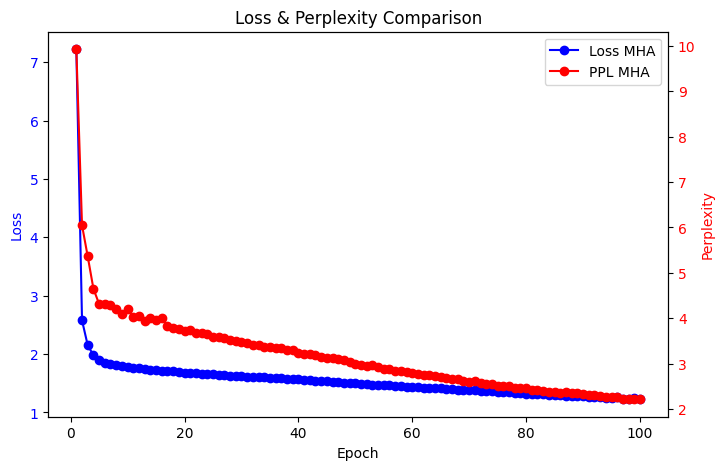

In [28]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_mha)+1)

fig, ax1 = plt.subplots(figsize=(8,5))

# ===== Loss =====
ax1.plot(epochs, loss_mha, 'b-o', label='Loss MHA')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# ===== PPL =====
ax2 = ax1.twinx()  # создаем вторую ось Y
ax2.plot(epochs, ppl_mha, 'r-o', label='PPL MHA')
ax2.set_ylabel('Perplexity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# ===== легенда =====
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Loss & Perplexity Comparison")
plt.show()

In [29]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to megabytes
    total_memory_mb = total_memory_bytes / (1024**2)

    return total_memory_mb

print(f"float32 (PyTorch default): {model_memory_size(transformer_mtp, input_dtype=torch.float32):.4f} MB")
print(f"bfloat16: {model_memory_size(transformer_mtp, input_dtype=torch.bfloat16):.4f} MB")

float32 (PyTorch default): 48.9883 MB
bfloat16: 24.4941 MB


# TEST MODEL

In [34]:
def generate(
    model: nn.Module,
    text_input: str,
    tokenizer: CharTokenizer,
    max_steps: int = 100,
    device: str = "cuda",
    temperature: float = 1.0,
    top_k: int = 50
) -> str:
    model.eval()
    model.to(device)

    # Токенизируем вход
    input_tokens = tokenizer.tokenize_ids(text_input)
    x = torch.tensor([input_tokens], dtype=torch.long, device=device)  # [1, T]

    generated_tokens = input_tokens.copy()

    for step in range(max_steps):
        with torch.no_grad():
            # **КЛЮЧЕВОЕ: используем ТОЛЬКО main prediction k=0**
            logits = model(x)  # [1, L, K, V]

            # Берем logits с последней позиции, main head (k=0)
            next_logits = logits[0, -1, 0] / temperature  # [V]

            # Top-K sampling
            if top_k > 0:
                v, _ = torch.topk(next_logits, min(top_k, next_logits.size(-1)))
                next_logits[torch.lt(next_logits, v[0])] = -float('Inf')

            probs = F.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        next_token_id = next_token.item()
        generated_tokens.append(next_token_id)

        # Останавливаемся на EOS
        if next_token_id == 4:  # <EOS>
            break

        # Добавляем токен к последовательности
        x = torch.cat([x, next_token.unsqueeze(0)], dim=1)

    return tokenizer.decode(generated_tokens)

In [35]:
transformer_mtp.eval()

MTPTransformer(
  (_embeddings): Embedding(77, 64, padding_idx=0)
  (main_layers): ModuleList(
    (0-5): 6 x DecoderLayer(
      (_mla): MultiHeadLatentAttention(
        (W_Q): Linear(in_features=64, out_features=64, bias=False)
        (W_C): Linear(in_features=64, out_features=16, bias=False)
        (W_K): Linear(in_features=16, out_features=64, bias=False)
        (W_V): Linear(in_features=16, out_features=64, bias=False)
        (W_O): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
      )
      (_fcnn): MoENoisyTopKGateFeedForward(
        (_gate): Linear(in_features=64, out_features=16, bias=False)
        (_noise_linear): Linear(in_features=64, out_features=16, bias=False)
        (_fc1): ModuleList(
          (0-15): 16 x Linear(in_features=64, out_features=256, bias=False)
        )
        (_fc2): ModuleList(
          (0-15): 16 x Linear(in_features=64, out_features=256, bias=False)
        )
        (_fc3): ModuleList

In [41]:
generate(
    model=transformer_mtp,
    text_input="Красотка",
    tokenizer=tokenizer,
    device=device,
)

'Красоткаиннрятаа и  БшББуиуурмттхаооанвв'